# Descrição
- Notebook mostra a criação de uma rede-neural para classificar câncer de mama como maligno ou benigno, através de imagens de ultrasom.
- Fonte Dataset: [https://data.mendeley.com/datasets/wmy84gzngw/1](https://data.mendeley.com/datasets/wmy84gzngw/1) [Rodrigues, Paulo Sergio (2017), “Breast Ultrasound Image”, Mendeley Data, V1, doi: 10.17632/wmy84gzngw.1]
- O dataset contém 250 imagens de câncer de mama, sendo 100 benignos e 150 malignos
- Site do datase: [https://data.mendeley.com/](https://data.mendeley.com/)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os, pathlib
from time import time
from PIL import Image
from random import choice
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
lista_imagens = list([str(i) for i in pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CLASSIFICAÇÃO CÂNCER DE MAMA/IMGS').glob('*/*.bmp')])
lista_imagens = [[v.split('/')[-2], v] for v in lista_imagens] # pega a classe
df = pd.DataFrame(lista_imagens, columns=['cancer_type', 'img_path'])
print (f'Total de imagens: {len(lista_imagens)}')
print (df['cancer_type'].value_counts())
df.head()

Total de imagens: 250
malignant    150
benign       100
Name: cancer_type, dtype: int64


,cancer_type,img_path
0,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...
1,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...
2,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...
3,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...
4,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...


# Análise das imagens

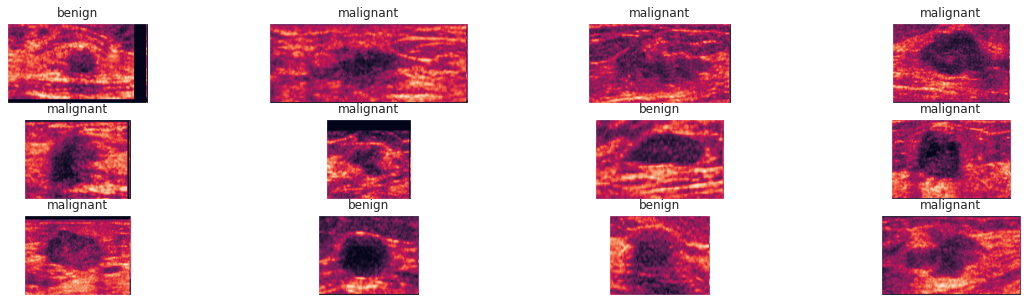

In [4]:
plt.figure(figsize=(20, 5))
df_sample = df.sample(12).values
for k, (cancer_type,img_path) in enumerate(df_sample):
    plt.subplot(3, 4, k+1)
    plt.imshow(Image.open(img_path))
    plt.xticks([])
    plt.yticks([])
    plt.title(cancer_type)
plt.show()

- Fazendo uma análise do shape das imagens

In [ ]:
def obter_shape(img_path_, n):
    return Image.open(img_path_).size[n]

df['width'] = df['img_path'].apply(obter_shape, args=(0,))
df['height'] = df['img_path'].apply(obter_shape, args=(1,))
df.head()

,cancer_type,img_path,width,height
0,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...,157,105
1,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...,123,69
2,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...,157,105
3,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...,99,71
4,benign,/content/drive/MyDrive/Colab Notebooks/CLASSIF...,97,95


In [ ]:
df.describe() # descreve a estatíscia de width e height para saber qual é o melhor valor para cada variável na hora de redimensionar

,width,height
count,250.000000,250.000000
mean,136.080000,97.680000
std,32.601303,25.515127
min,75.000000,57.000000
25%,105.000000,77.000000
50%,139.000000,93.000000
75%,163.000000,111.000000
max,199.000000,161.000000


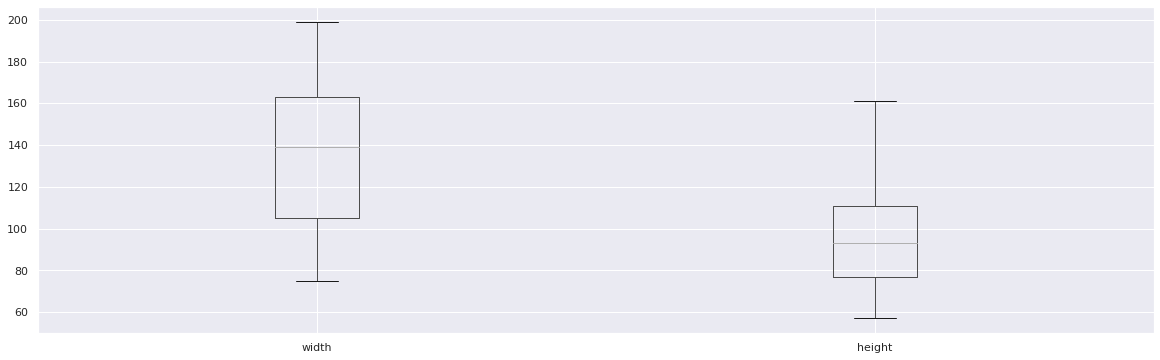

In [ ]:
df.boxplot(column=['width', 'height'], figsize=(20, 6), )
plt.show()

- Decidido, então, que as imagens serão redimensionadas para 100 x 100

# Classe Dataset

In [3]:
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
    transforms.Resize(size=(100, 100)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=6), # de acordo com cálculos
    transforms.CenterCrop(size=(90, 90)),
    transforms.Resize(size=(100, 100))
])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
    transforms.Resize(size=(100, 100))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=-1., std=2.),
    transforms.ToPILImage()
])

CANCERTYPE2IDX = {'benign': 0,'malignant': 1}
IDX2CANCERTYPE = {0: 'benign',1: 'malignant'}

class Custom_Dataset(Dataset):
    
    def __init__(self, lista, dataset_type):
        self.lista = lista
        self.dataset_type = dataset_type # train, test
        self.df = pd.DataFrame(self.lista, columns=['cancer_type', 'img_path'])
        self.w, self.h = 136, 100
        self.transformer = train_transformer if dataset_type == 'train' else test_transformer
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        cancer_type, img_path = self.df.values[index]
        img_tensor = self.transformer(np.array(Image.open(img_path)))
        target_tensor = torch.tensor([CANCERTYPE2IDX[cancer_type]])/1.
        return img_tensor, target_tensor

dataset = Custom_Dataset(lista_imagens, 'train')
img_tensor, target_tensor = choice(dataset)
print (f'img_tensor.shape: {img_tensor.shape}, target_tensor: {target_tensor}')

img_tensor.shape: torch.Size([1, 100, 100]), target_tensor: tensor([0.])


- Avaliando os transformers e inv_transformers

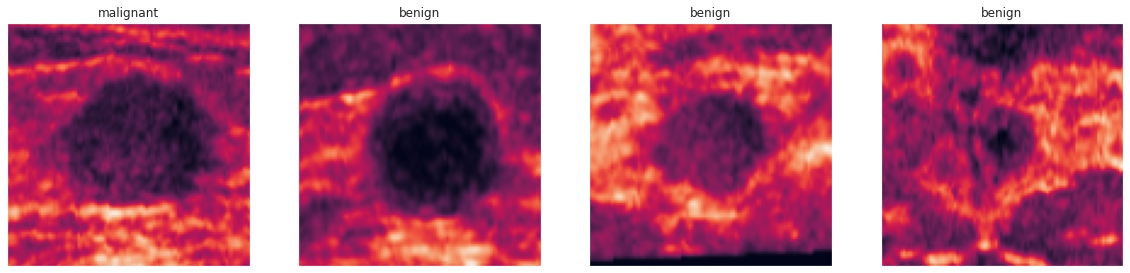

In [4]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
img_batch, target_batch = next(iter(dataloader))
plt.figure(figsize=(20, 50))
for k, (img_tensor, target_tensor) in enumerate(zip(img_batch, target_batch)):
    plt.subplot(1, 4, k+1)
    img_pil = inv_transformer(img_tensor)
    plt.imshow(img_pil)
    plt.xticks([])
    plt.yticks([])
    plt.title(IDX2CANCERTYPE[int(target_tensor)])

plt.show()

# Rede Neural

In [5]:
architecture = [
    ['Conv2d', 1, 64, 5, 1, 0],
    ['Conv2d', 64, 128, 3, 1, 0],
    ['Maxpool2d', 2, 2],
    ['Conv2d', 128, 256, 3, 1, 0],
    ['Conv2d', 256, 256, 3, 1, 0],
    ['Maxpool2d', 2, 2],
    ['Conv2d', 256, 128, 5, 1, 0],
    ['Conv2d', 128, 128, 3, 1, 0],
    ['Maxpool2d', 2, 2],
    ['Flatten'],
    ['Linear', -1, 1024], ['LeakyRelu'],
    ['Linear', 1024, 1024], ['LeakyRelu'],
    ['Linear', 1024, -1], ['Sigmoid']
]

class Model(nn.Module):

    def __init__(self, input_size, output_size, architecture):
        super(Model, self).__init__()
        self.input_size = input_size
        self.architecture = architecture
        self.neuronios = -1
        self.output_size = output_size

        self.camadas = []
        for camada in self.architecture:
            self.camadas.append(self.construir(camada))
            if camada[0] == 'Flatten': self.calcular_neuronios()
        
        self.net = nn.Sequential(*self.camadas)
    
    def construir(self, c):
        tipo = c[0]
        
        if tipo == 'Conv2d':
            return nn.Sequential(
                nn.Conv2d(in_channels=c[1], out_channels=c[2], kernel_size=c[3], stride=c[4], padding=c[5]),
                nn.BatchNorm2d(num_features=c[2]),
                nn.LeakyReLU()
            )
        
        if tipo == 'Maxpool2d':
            return nn.MaxPool2d(kernel_size=c[1], stride=c[2])
        
        if tipo == 'Flatten':
            return nn.Flatten()
        
        if tipo == 'Linear':
            input_ = self.neuronios if c[1] == -1 else c[1]
            output_ = self.output_size if c[2] == -1 else c[2]
            return nn.Linear(in_features=input_, out_features=output_)
        
        if tipo == 'LeakyRelu': return nn.LeakyReLU()

        if tipo == 'Sigmoid': return nn.Sigmoid()
    
    def calcular_neuronios(self):
        input_test = torch.rand((1, 1, self.input_size, self.input_size))
        model_test = nn.Sequential(*self.camadas)
        output_test = model_test(input_test)
        self.neuronios = output_test.shape[-1]

    def forward(self, x):
        return self.net(x)

model = Model(100, 1, architecture)
output = model(img_batch)
print (f'output.shape: {output.shape}')

output.shape: torch.Size([4, 1])


# Treinamento

In [6]:
def avaliar_metricas(real_values_, predict_values_, threshold = 0.8):
    """
    - Esta função serve para avaliar as principais métricas utilizadas para um classificador binário.
    - O vetor predict_values_ é refeito com valores 0 ou 1 a partir de um threshold.
    - Necessário informar dois vetores, de uma dimensão, com  mesmo tamanho.
    - Args: 
        real_values_ e predict_values_ são vetores numpy já em cpu de uma dimensão.
    - Returns: 
        - accuracy, precision, recall
    """
    predict_values_ = (predict_values_ > threshold) * 1 # essa parte refaz o vetor tornando ele em zero ou 1 somente, a partir de um threshold

    accuracy = accuracy_score(real_values_, predict_values_)
    precision = precision_score(real_values_, predict_values_)
    recall = recall_score(real_values_, predict_values_)

    return accuracy, precision, recall

def validar(model_: Model, dataloader_: DataLoader, loss_fn_: nn.Module, device_: torch.device, threshold = 0.8):
    model_.eval()
    with torch.no_grad():
        real_values, predict_values, test_loss = [], [], []
        for imgs_tensor, target_tensor in dataloader_:
            imgs_tensor, target_tensor = imgs_tensor.to(device_), target_tensor.to(device_)
            predict_tensor = model_(imgs_tensor)
            loss = loss_fn_(predict_tensor, target_tensor)
            test_loss.append(loss.item())

            real_values.append(target_tensor)
            predict_values.append(predict_tensor)
        
    real_values = torch.vstack(real_values).detach().cpu().numpy().reshape(-1)
    predict_values = torch.vstack(predict_values).detach().cpu().numpy().reshape(-1)

    accuracy, precision, recall = avaliar_metricas(real_values, predict_values)

    test_loss = np.array(test_loss).mean()

    return test_loss, accuracy, precision, recall

dataset = Custom_Dataset(lista_imagens[-10:], 'train')
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
validar(model, dataloader, nn.BCELoss(), torch.device('cpu'))

(0.6877507368723551, 0.0, 0.0, 0.0)

In [13]:
ARCHITECTURE = [
    ['Conv2d', 1, 256, 5, 1, 0],
    ['Conv2d', 256, 256, 3, 1, 0],
    ['Maxpool2d', 2, 2],
    ['Conv2d', 256, 512, 5, 1, 0],
    ['Conv2d', 512, 512, 3, 1, 0],
    ['Maxpool2d', 2, 2],
    ['Conv2d', 512, 512, 5, 1, 0],
    ['Conv2d', 512, 512, 3, 1, 0],
    ['Maxpool2d', 2, 2],
    ['Flatten'],
    ['Linear', -1, 4096], ['LeakyRelu'],
    ['Linear', 4096, 4096], ['LeakyRelu'],
    ['Linear', 4096, -1], ['Sigmoid']
]

BATCH_SIZE = 4
LEARNING_RATE = 2e-4
EPOCHS = 30
INPUT_SIZE = 100 # Tamanho que as imagens vão ser redimensionadas
THRESHOLD = 0.5

lista_imagens = list([str(i) for i in pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CLASSIFICAÇÃO CÂNCER DE MAMA/IMGS').glob('*/*.bmp')]) # pegando as imagens novamente
lista_imagens = [[v.split('/')[-2], v] for v in lista_imagens] # pega a classe

df = pd.DataFrame(lista_imagens, columns=['cancer_type', 'img_path']) # criando um dataframe pois é mais fácil manusear

df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['cancer_type']) # Separando o dataset em treino-teste

train_dataset = Custom_Dataset(lista = df_train.values, dataset_type = 'train')
test_dataset = Custom_Dataset(lista = df_test.values, dataset_type = 'test')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(input_size = INPUT_SIZE, output_size = 1, architecture = ARCHITECTURE)
model.to(DEVICE)

loss_fn = nn.BCELoss().to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.6)

cabecalho = ['epoch', 'train_loss', 'train_accuracy','train_precision', 'train_recall', 'test_loss', 'test_accuracy','test_precision', 'test_recall']
print (' | '.join([str(c).center(18) for c in cabecalho]))
results = []

for epoch in range(EPOCHS):

    model.train()
    train_loss, real_values, predict_values = [], [], []

    for imgs_tensor, target_tensor in tqdm(train_dataloader):
        imgs_tensor, target_tensor = imgs_tensor.to(DEVICE), target_tensor.to(DEVICE)
        
        optimizer.zero_grad()
        predict_tensor = model(imgs_tensor)
        loss = loss_fn(predict_tensor, target_tensor)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

        real_values.append(target_tensor)
        predict_values.append(predict_tensor)
    
    train_loss = np.array(train_loss).mean()

    real_values = torch.vstack(real_values).detach().cpu().numpy().reshape(-1)
    predict_values = torch.vstack(predict_values).detach().cpu().numpy().reshape(-1)

    train_accuracy, train_precision, train_recall = avaliar_metricas(real_values, predict_values, THRESHOLD)

    test_loss, test_accuracy, test_precision, test_recall = validar(model, test_dataloader, loss_fn, DEVICE, THRESHOLD)

    vetor = [epoch, train_loss, train_accuracy, train_precision, train_recall, test_loss, test_accuracy, test_precision, test_recall]
    print (' | '.join([str(round(v, 3)).center(18) for v in vetor]))
    results.append(vetor)

    scheduler.step()


      epoch        |     train_loss     |   train_accuracy   |   train_precision  |    train_recall    |     test_loss      |   test_accuracy    |   test_precision   |    test_recall    


100%|██████████| 57/57 [00:10<00:00,  5.67it/s]


        0          |       0.964        |       0.684        |        0.75        |       0.711        |       1.134        |        0.56        |        1.0         |       0.267       


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]


        1          |       0.733        |       0.671        |       0.707        |        0.77        |       0.579        |        0.52        |        0.8         |       0.267       


100%|██████████| 57/57 [00:10<00:00,  5.51it/s]


        2          |        0.6         |       0.729        |       0.768        |       0.785        |       0.491        |        0.56        |        1.0         |       0.267       


100%|██████████| 57/57 [00:10<00:00,  5.48it/s]


        3          |       0.497        |       0.778        |       0.806        |        0.83        |       0.595        |        0.68        |       0.889        |       0.533       


100%|██████████| 57/57 [00:10<00:00,  5.38it/s]


        4          |       0.475        |       0.787        |       0.822        |       0.822        |       0.631        |        0.68        |       0.706        |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]


        5          |       0.487        |       0.778        |       0.801        |       0.837        |       0.548        |        0.8         |       0.778        |       0.933       


100%|██████████| 57/57 [00:10<00:00,  5.64it/s]


        6          |       0.445        |       0.831        |       0.826        |       0.911        |       1.045        |        0.48        |        1.0         |       0.133       


100%|██████████| 57/57 [00:10<00:00,  5.49it/s]


        7          |       0.468        |       0.782        |       0.803        |       0.844        |       0.821        |        0.8         |       0.857        |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]


        8          |       0.418        |       0.813        |        0.83        |       0.867        |       0.543        |        0.6         |        1.0         |       0.333       


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]


        9          |       0.398        |       0.849        |       0.869        |       0.881        |        0.29        |        0.84        |        1.0         |       0.733       


100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


        10         |       0.273        |        0.88        |       0.897        |       0.904        |       0.256        |        0.84        |        1.0         |       0.733       


100%|██████████| 57/57 [00:10<00:00,  5.55it/s]


        11         |       0.289        |       0.867        |       0.883        |       0.896        |       0.286        |        0.84        |        1.0         |       0.733       


100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


        12         |       0.272        |       0.902        |       0.919        |       0.919        |       0.322        |        0.76        |        1.0         |        0.6        


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


        13         |       0.218        |        0.92        |       0.933        |       0.933        |       0.231        |        0.88        |        1.0         |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]


        14         |       0.222        |       0.916        |       0.946        |       0.911        |       0.258        |        0.84        |       0.923        |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


        15         |       0.217        |       0.916        |       0.926        |       0.933        |       0.154        |        0.8         |        1.0         |       0.667       


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


        16         |       0.154        |       0.933        |       0.948        |       0.941        |       0.355        |        0.84        |       0.923        |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


        17         |       0.238        |       0.924        |       0.947        |       0.926        |       0.507        |        0.84        |       0.923        |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


        18         |       0.196        |       0.916        |        0.92        |       0.941        |        0.17        |        0.88        |       0.929        |       0.867       


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]


        19         |       0.136        |       0.951        |       0.963        |       0.956        |        0.21        |        0.92        |       0.933        |       0.933       


100%|██████████| 57/57 [00:10<00:00,  5.52it/s]


        20         |       0.102        |       0.964        |        0.97        |        0.97        |       0.134        |        0.92        |        1.0         |       0.867       


100%|██████████| 57/57 [00:11<00:00,  5.01it/s]


        21         |       0.135        |       0.956        |       0.963        |       0.963        |       0.253        |        0.84        |       0.923        |        0.8        


100%|██████████| 57/57 [00:11<00:00,  5.10it/s]


        22         |       0.138        |        0.96        |       0.977        |       0.956        |       0.058        |        0.96        |        1.0         |       0.933       


100%|██████████| 57/57 [00:11<00:00,  4.76it/s]


        23         |       0.266        |       0.884        |       0.936        |       0.867        |       0.137        |        0.92        |        1.0         |       0.867       


100%|██████████| 57/57 [00:10<00:00,  5.41it/s]


        24         |       0.081        |       0.969        |       0.978        |        0.97        |       0.171        |        0.88        |       0.929        |       0.867       


100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


        25         |       0.112        |       0.951        |       0.956        |       0.963        |       0.237        |        0.84        |       0.923        |        0.8        


100%|██████████| 57/57 [00:10<00:00,  5.58it/s]


        26         |       0.119        |       0.973        |       0.985        |        0.97        |       0.099        |        0.96        |        1.0         |       0.933       


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]


        27         |        0.12        |       0.947        |       0.956        |       0.956        |       0.112        |        0.96        |        1.0         |       0.933       


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


        28         |       0.094        |       0.969        |       0.978        |        0.97        |        0.17        |        0.92        |       0.933        |       0.933       


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


        29         |       0.043        |       0.982        |       0.992        |       0.978        |       0.051        |        1.0         |        1.0         |        1.0        


# Resultados

In [30]:
r = pd.DataFrame(results, columns=cabecalho)
r.set_index('epoch', inplace=True)
r.head()

,train_loss,train_accuracy,train_precision,train_recall,test_loss,test_accuracy,test_precision,test_recall
epoch,,,,,,,,
0,0.963546,0.684444,0.750000,0.711111,1.133874,0.56,1.000000,0.266667
1,0.732730,0.671111,0.707483,0.770370,0.578891,0.52,0.800000,0.266667
2,0.600179,0.728889,0.768116,0.785185,0.491283,0.56,1.000000,0.266667
3,0.497089,0.777778,0.805755,0.829630,0.594943,0.68,0.888889,0.533333
4,0.474969,0.786667,0.822222,0.822222,0.631455,0.68,0.705882,0.800000


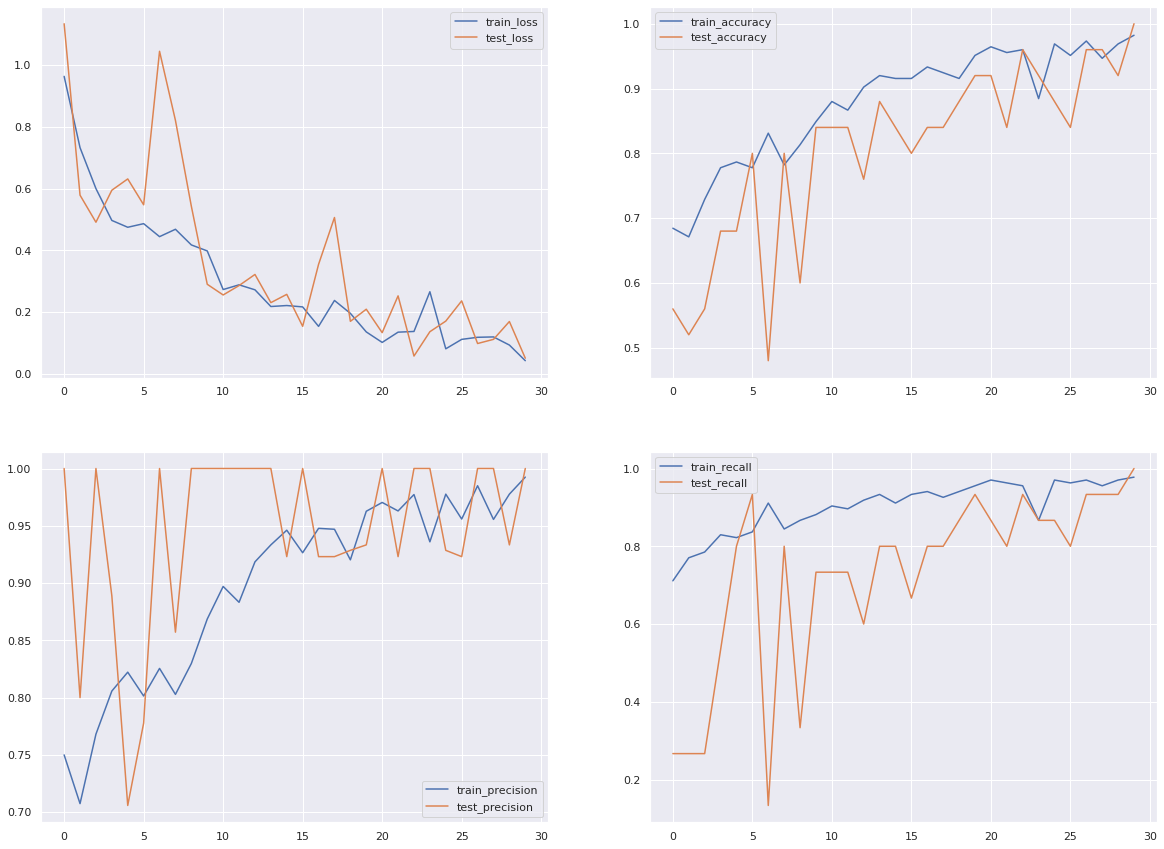

In [39]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(r['train_loss'], label='train_loss')
plt.plot(r['test_loss'], label='test_loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(r['train_accuracy'], label='train_accuracy')
plt.plot(r['test_accuracy'], label='test_accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(r['train_precision'], label='train_precision')
plt.plot(r['test_precision'], label='test_precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(r['train_recall'], label='train_recall')
plt.plot(r['test_recall'], label='test_recall')
plt.legend()

plt.show()

# Salvando o modelo

In [52]:
checkpoint = {
    'state-dict': model.state_dict(),
    'ARCHITECTURE': ARCHITECTURE,
    'BATCH_SIZE': 4,
    'LEARNING_RATE': 2e-4,
    'EPOCHS': 30,
    'INPUT_SIZE': 100, 
    'THRESHOLD': 0.5
}
torch.save(checkpoint, '/content/drive/MyDrive/Colab Notebooks/CLASSIFICAÇÃO CÂNCER DE MAMA/checkpoint.pth')

 # Carregando modelo

In [7]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/CLASSIFICAÇÃO CÂNCER DE MAMA/checkpoint.pth', map_location=torch.device('cpu'))

In [12]:
ARCHITECTURE = checkpoint['ARCHITECTURE']
INPUT_SIZE = checkpoint['INPUT_SIZE']
model = Model(input_size=INPUT_SIZE, output_size=1, architecture=ARCHITECTURE)
print (model.load_state_dict(checkpoint['state-dict']))

<All keys matched successfully>


# Análise de algumas imagens teste

In [15]:
predict_values, real_values, imgs_list = [], [], []
model.eval()
for imgs_tensor, target_tensor in tqdm(test_dataloader):
    predict_tensor = model(imgs_tensor)

    predict_values.append(predict_tensor)
    real_values.append(target_tensor)
    imgs_list.append(imgs_tensor.detach().cpu())

predict_values = torch.vstack(predict_values).detach().cpu().numpy().reshape(-1)
real_values = torch.vstack(real_values).detach().cpu().numpy().reshape(-1)
imgs_list = torch.vstack(imgs_list)

100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


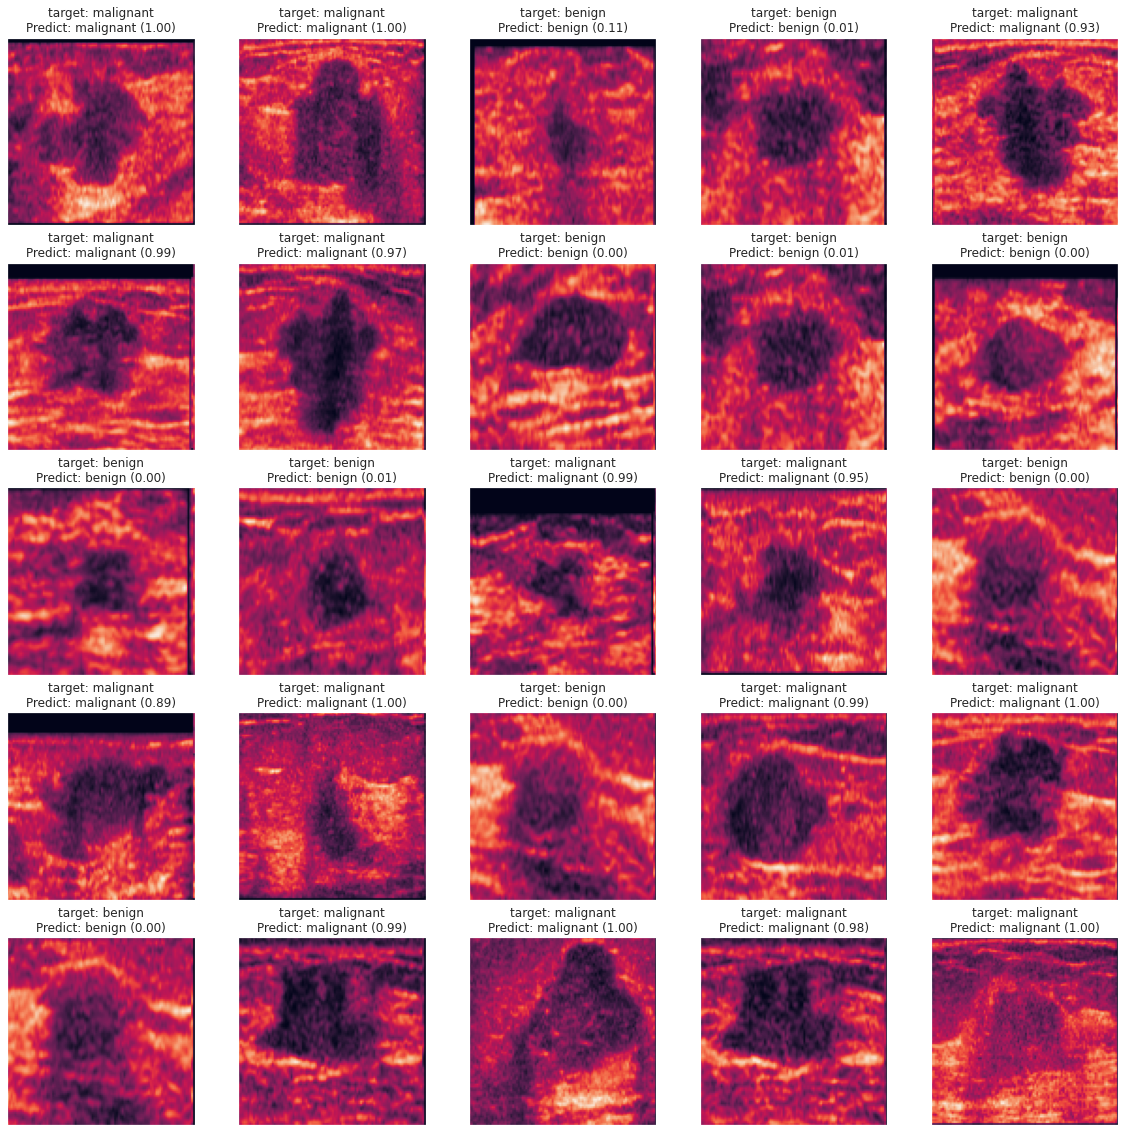

In [24]:
plt.figure(figsize=(20, 20))

for k, (img_tensor, real_value, predict_value) in enumerate(zip(imgs_list, real_values, predict_values)):
    
    plt.subplot(5, 5, k+1)
    img_pil = inv_transformer(img_tensor)
    plt.imshow(img_pil)
    plt.xticks([])
    plt.yticks([])
    real_class = IDX2CANCERTYPE[int(real_value)]
    predict_class = IDX2CANCERTYPE[1 if predict_value > 0.5 else 0]
    titulo = f'target: {real_class}\nPredict: {predict_class} ({predict_value:0.02f})'
    plt.title(titulo)

plt.show()